<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>


<br> <a href="./4_S6_SLAs.ipynb"><< 4 - S6 Sea-level anomalies </a><span style="float:right;"><a href="S6_overview.ipynb">Back to S6 overview >></a> 
    

## First look at altimetry waveforms for two different modes ##

As part of Copernicus, EUMETSAT operates the Poseidon-4 altimeter on Sentinel-6.

Waveforms are the fundamental signal that altimeters receive, and from which they derive all their information about the ocean surface. The shape of a waveform is determined by how a radar pulse interacts with the Earth's surface. Much more information on waveforms can be found here:

http://www.altimetry.info/radar-altimetry-tutorial/how-altimetry-works/from-radar-pulse-to-altimetry-measurements/

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib import dates

In [2]:
#we will look at the plot within the notebooks
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()
matplotlib.rcParams.update({'font.size': 16})

To help to find your data, please complete the MYPATH variable below with the output generated by the /Configuration_Testing/Data_Path_Checker.ipynb Jupyter notebook in the Configuration_Testing folder. 

In [3]:
# e.g. MYPATH = os.path.join("C:/","Users","me","Desktop")
#MYPATH = os.cwd()
MYPATH = ''

We will start by plotting Sentinel-6 'low resolution' data. This Low Resolution Mode or LRM is what is processed for the classical altimeter such as Jason-3. It will give us a classical, "Brown" waveform (over the ocean).

latitude where the measurement is: 15.964309


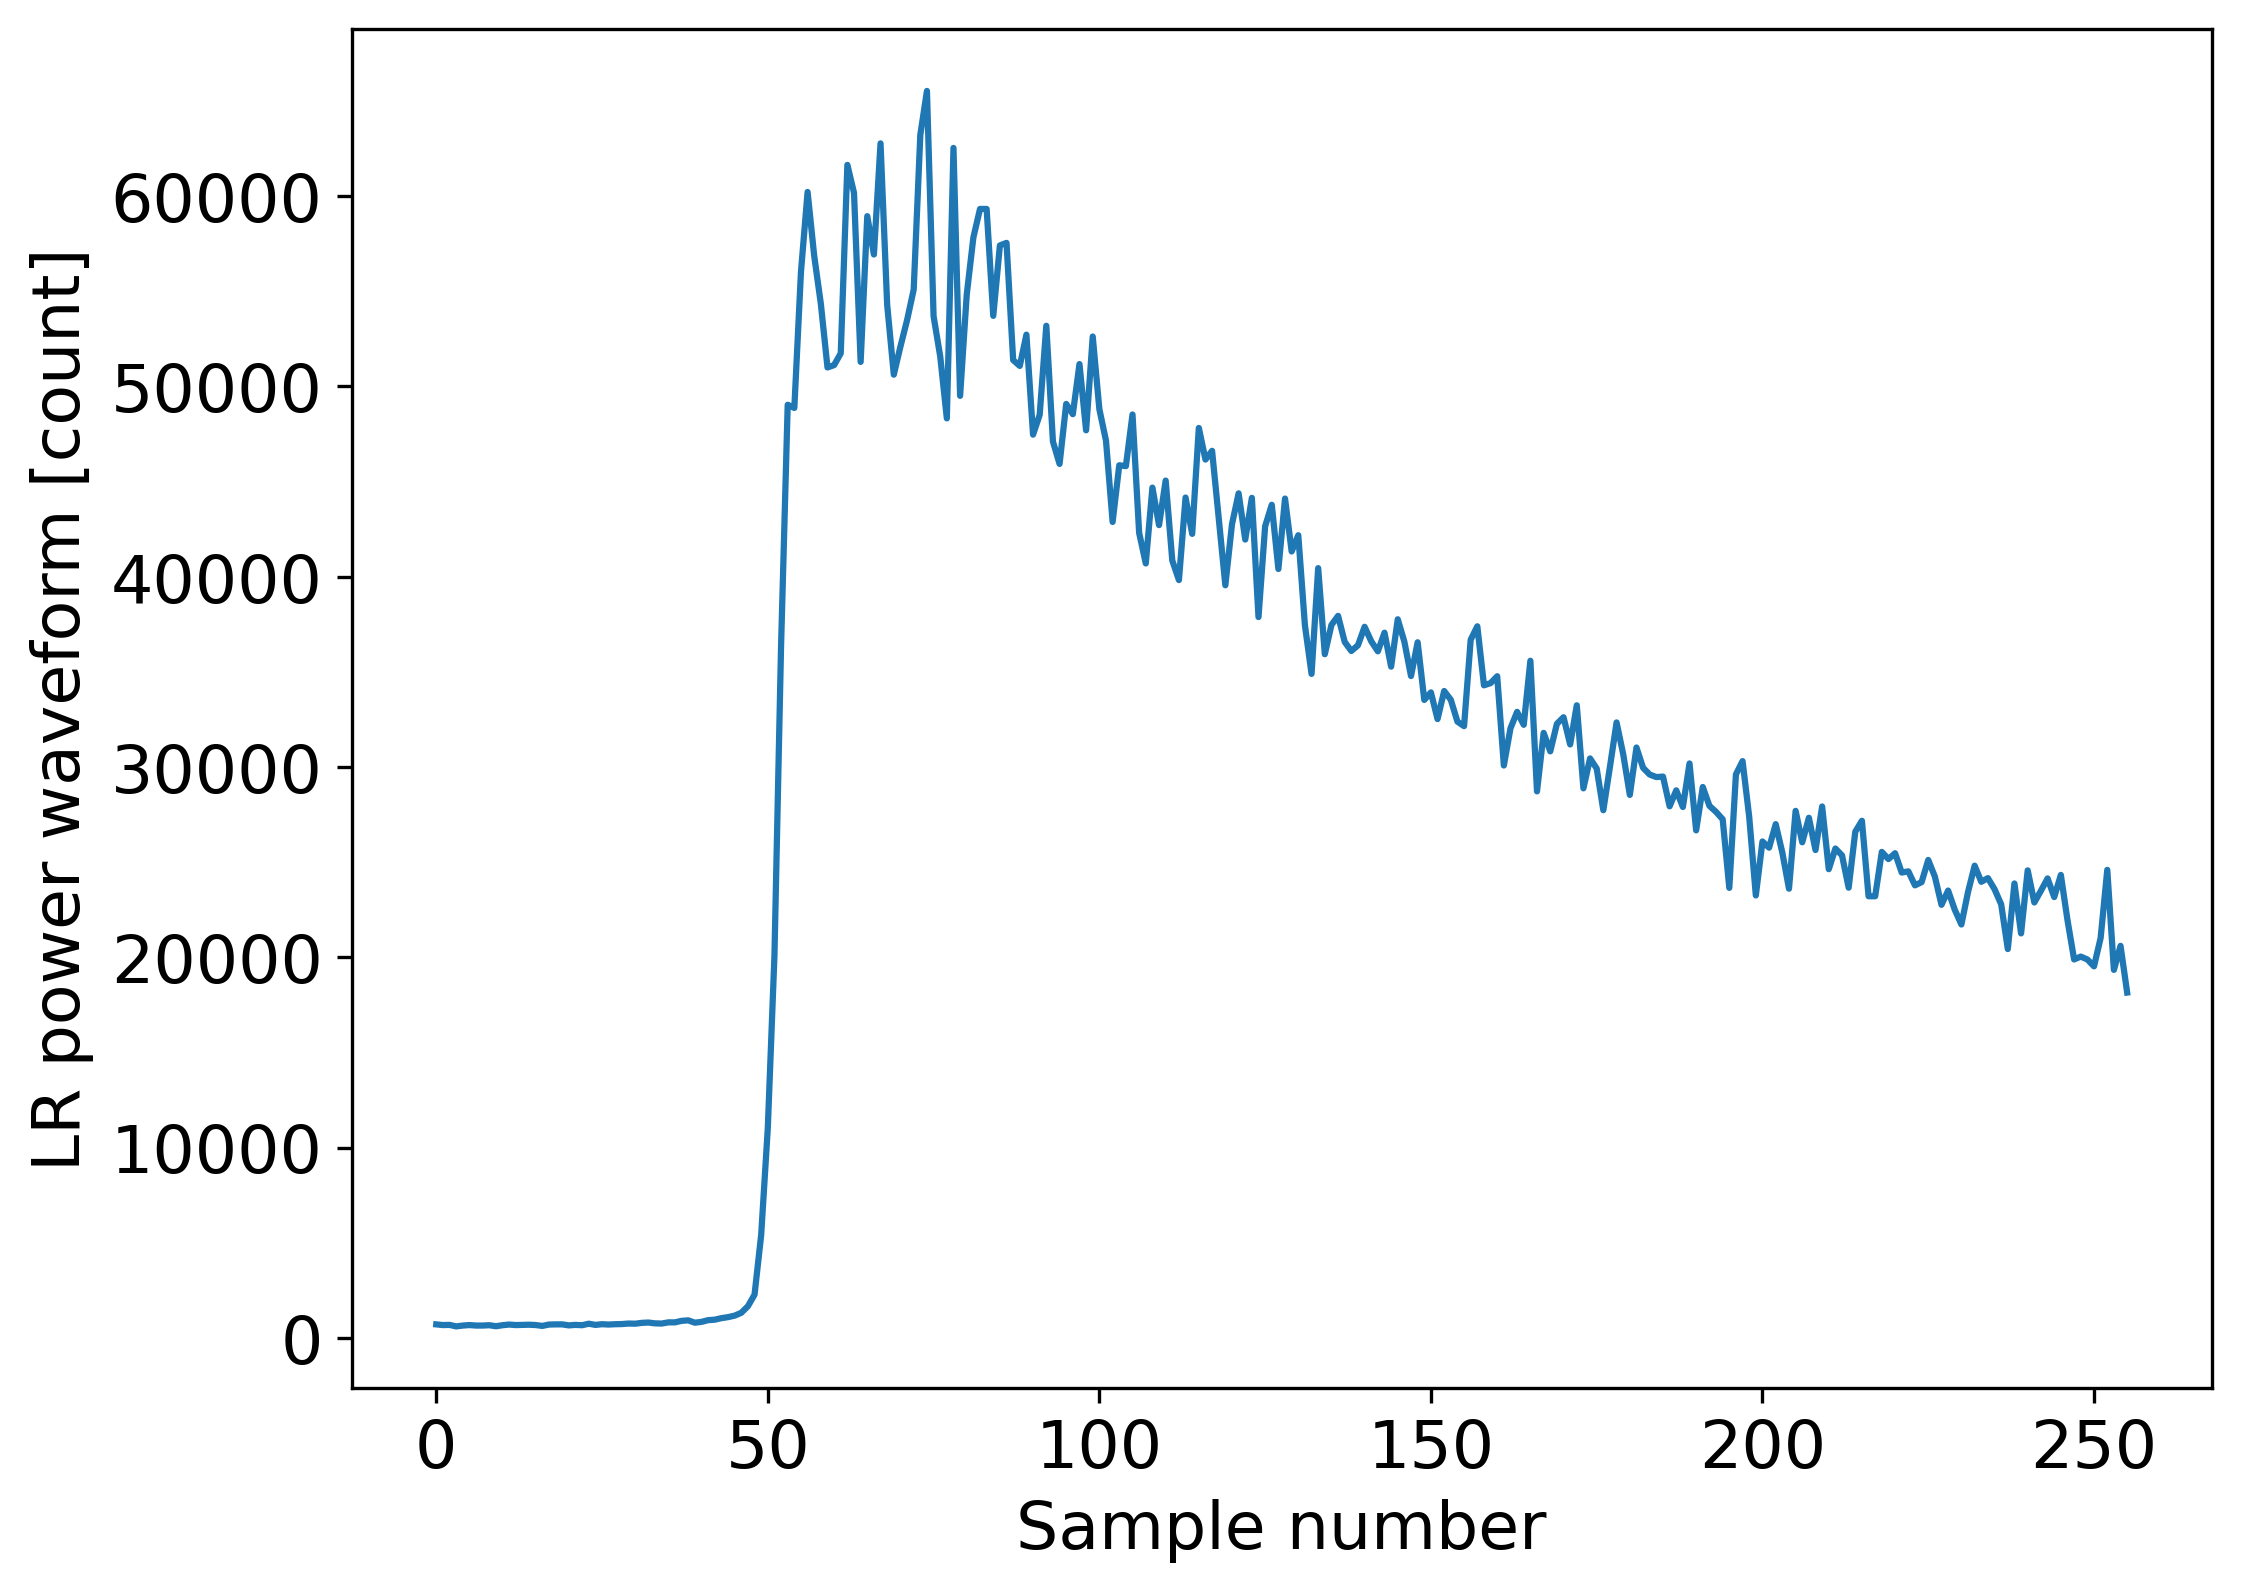

In [4]:
#try and look for waveforms at different indexes (first index is the array at 1Hz, second is the index within the 20Hz array)
#most of the track used is over calm seas (except around 55°S)
input_root = os.path.join(MYPATH,'S6_data')
input_path = 'S6A_P4_1B_LR______20210907T150745_20210907T160358_20210928T114951_3373_030_165_082_EUM__OPE_NT_F03.SEN6'
input_file = 'measurement.nc'

my_file = os.path.join(input_root,input_path,input_file)
# data are structured in groups; you use each group as you would a separate file.
nc20ku = xr.open_dataset(my_file, group='data_20/ku')

lat_20 = nc20ku.variables['latitude'][:]
#swh_ku = nc20ku.variables['swh_ku'][:]
waveforms_lr_20hz_ku = nc20ku.variables['power_waveform'][:,:]
waveform_scale_factor_lr=nc20ku.variables['waveform_scale_factor'][:]
nc20ku.close()

#the dimension is time; we choose a time when the satellite is over open ocean by its index
time_index = 40000
print('latitude where the measurement is:', lat_20[time_index].values)

fig = plt.figure(figsize=(8, 6), dpi=300)
plt.plot(waveforms_lr_20hz_ku[time_index,:])
plt.xlabel('Sample number', fontsize=16)
plt.ylabel('LR power waveform [count]',  fontsize=16)
plt.show()

For details on what information different parts of the waveform give us, please read: 
    http://www.altimetry.info/radar-altimetry-tutorial/how-altimetry-works/from-radar-pulse-to-altimetry-measurements/5-1-2-3-altimetric-measurements-over-the-ocean/

Now we will make a similar plot for the High Resolution data of Sentinel-6. In this dataset, the Synthetic Aperture Radar processing is used.

Poseidon-4 operates in Delay-Doppler (SAR) mode, and therefore the waveforms over the ocean will be "peakier" than the conventional "Low Resolution Mode" ones over ocean. 
The fact this radar is emitting/receiving alternatively enables to compute both modes at the same time (while only a 'pseudo' low resolution mode is available for Sentinel-3 SRAL, which emits by bursts, then receive during a twice as long time).

Note that both data are natively scaled on 0-65534, so the amplitude is not relevant above; the shape of both curves will be different in a calm area than over rough seas. 
To scale to a power in Watts:
power_waveform_watt(time, sample) = power_waveform(time, sample) * waveform_scale_factor(time)

Another difference between HR and LR is the number of samples in the waveforms. HR waveforms are oversampled, ending up with 512 samples, while "only" 256 samples are used for Low resolution (this for a question of easier fitting of the leading edge (the rising slope of the curve) to the model when it is very steep). Note that for most of the altimeters, this number is 128. Using more samples provide with the "tail" of the curve, which gives information on the antenna pointing strictly to nadir, or mispointing slightly (which in turn impacts some estimates computed from the waveform shape). 
One last difference between HR data themselves: close to the coasts, the tail of the waveform is provided (HR "raw"), while it is cut in the open ocean (HR "RMC" or range migration correction).This is done to reduce on-board storage and downlink.

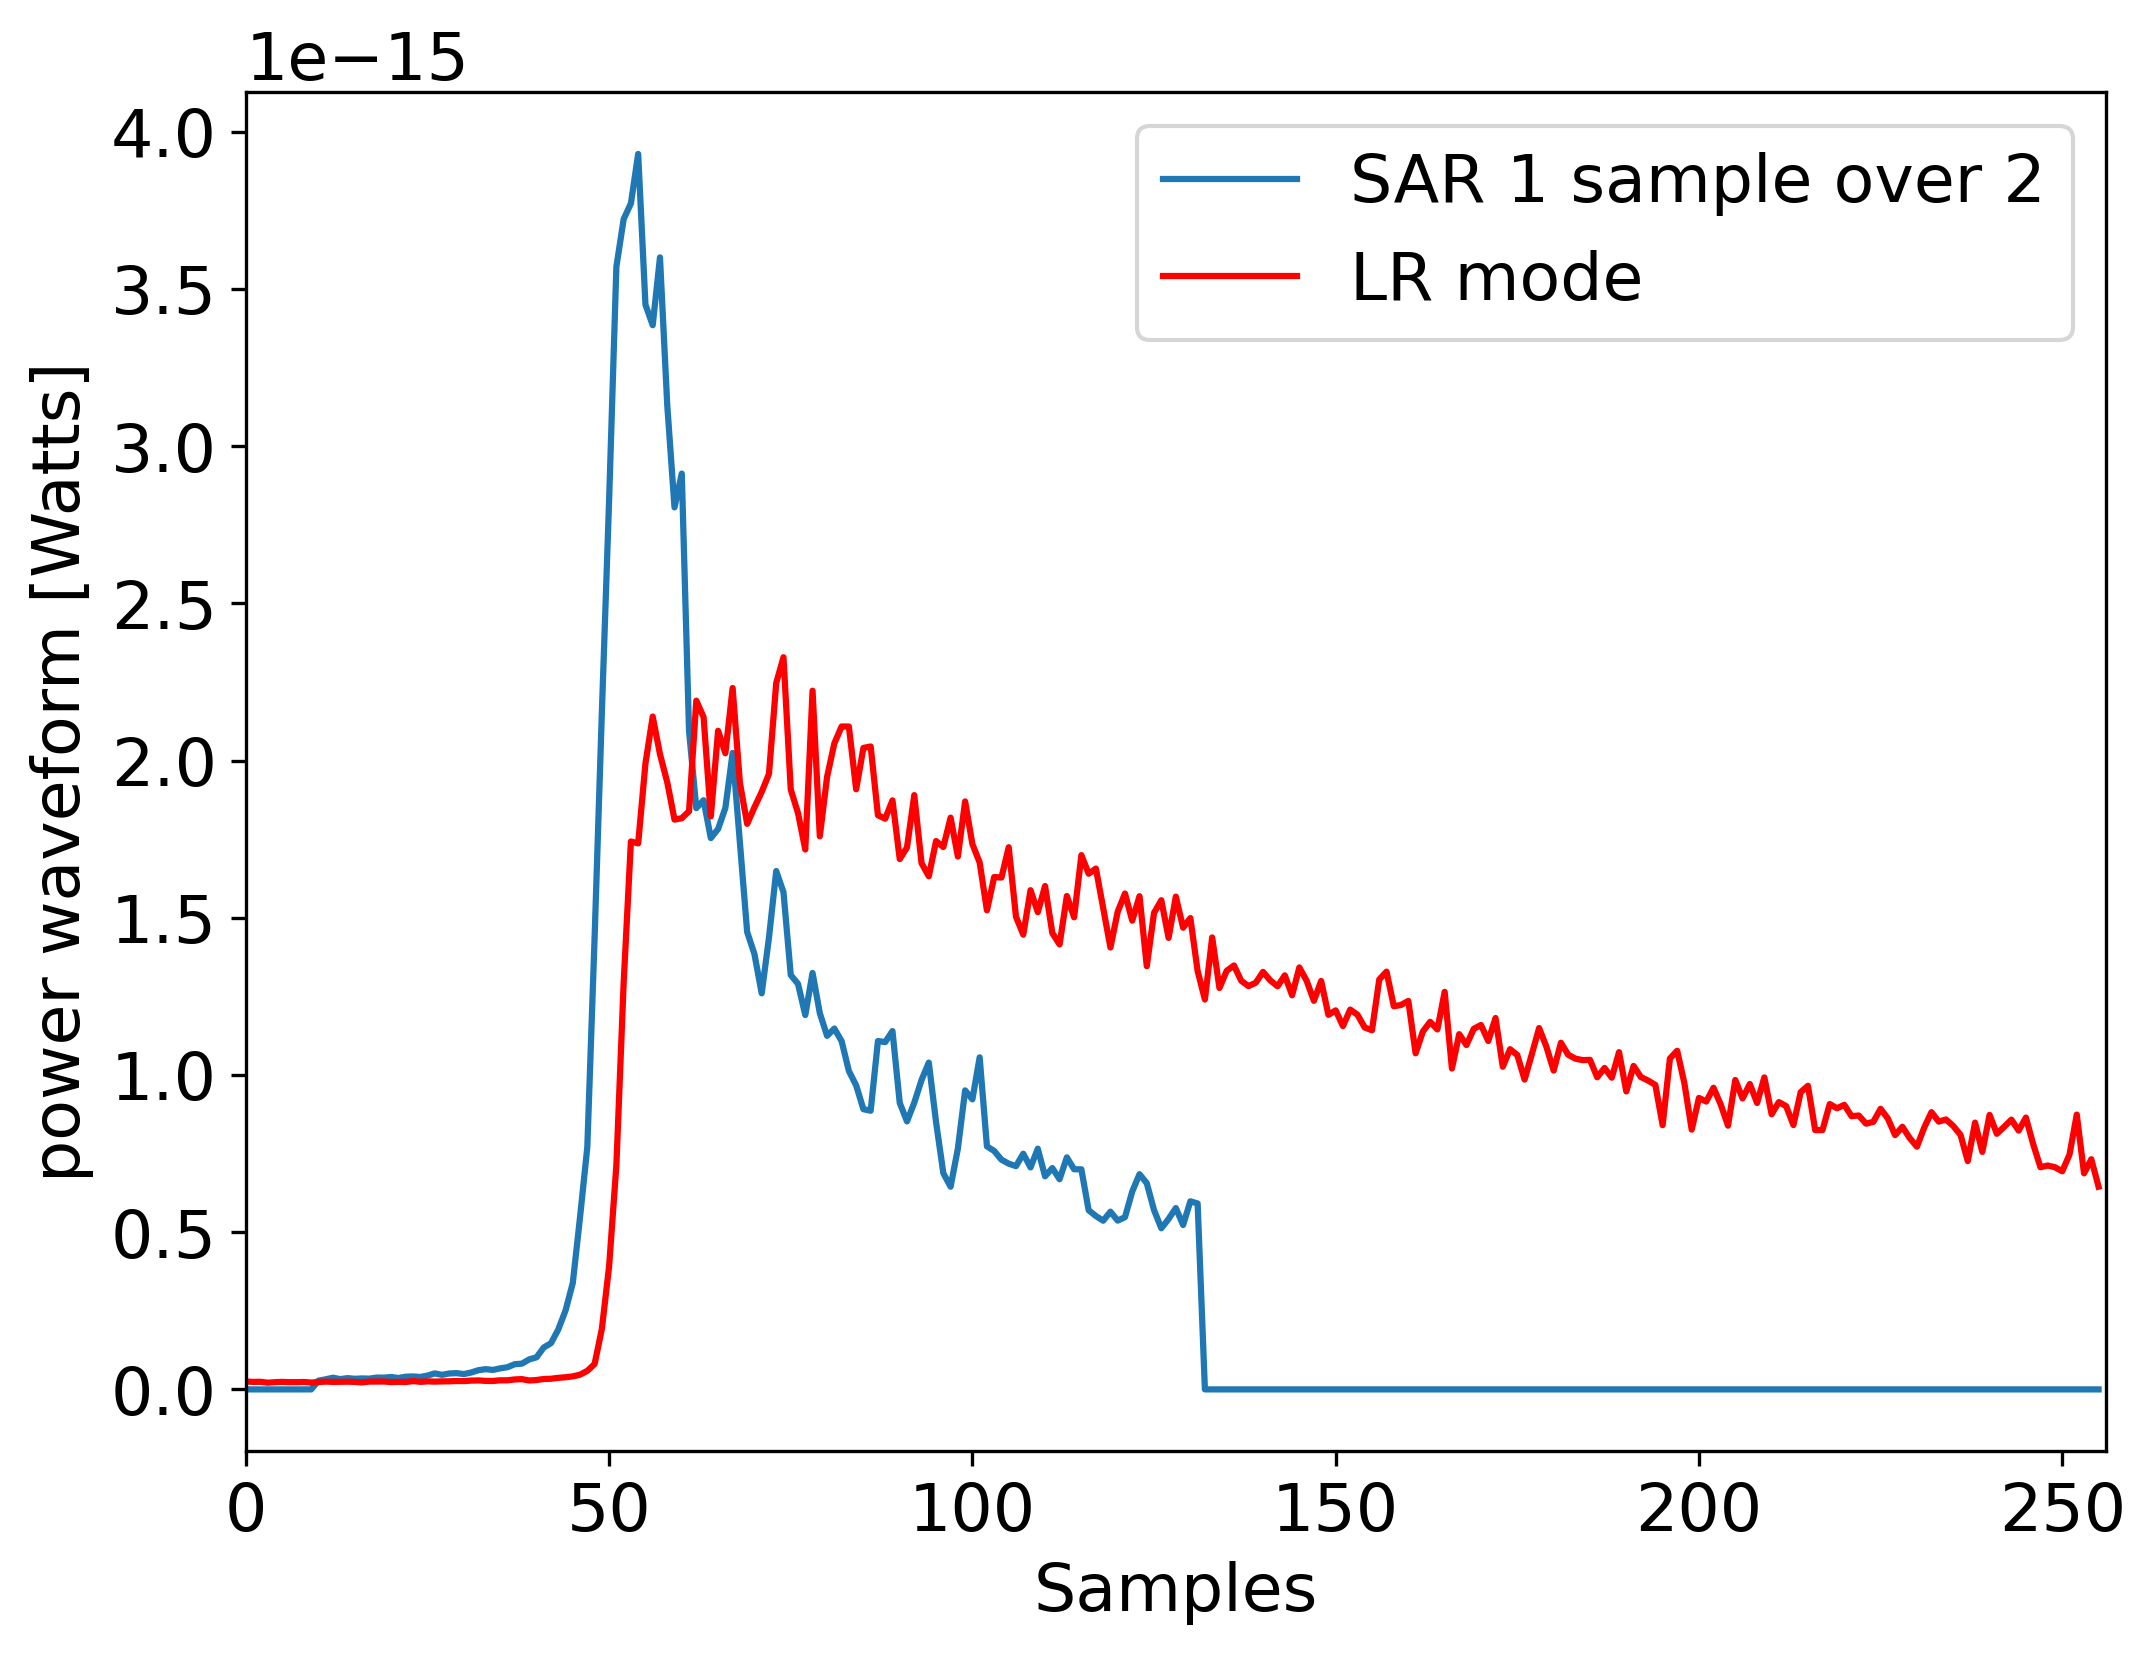

In [5]:
input_root = os.path.join(MYPATH,'s6_data')
input_path = 'S6A_P4_1B_HR______20210907T150745_20210907T160322_20210929T181726_3337_030_165_082_EUM__OPE_NT_F03.SEN6'
input_file = 'measurement.nc'
my_file    = os.path.join(input_root,input_path,input_file)
nc20ku = xr.open_dataset(my_file, group='data_20/ku')

lat_20 = nc20ku.variables['latitude'][:]
lon_20 = nc20ku.variables['longitude'][:]
#swh_ku = nc20ku.variables['swh_ku'][:]
waveforms_hr_20hz_ku = nc20ku.variables['power_waveform'][:,:]
waveform_scale_factor_hr = nc20ku.variables['waveform_scale_factor'][:]
nc20ku.close()

#a few different cases from their index -- see above cell to check on the latitude.
#RAW HR waveform (large coastal areas)
#time_index=50000
#RMC HR waveform (open ocean)
time_index=40000
#waveform close to hurricane Larry's eye. at 25.04°N 
#time_index=43750

fig = plt.figure(figsize=(8, 6), dpi=300)
ax = plt.subplot(1,1,1)
#p1, = ax.plot(waveforms_hr_20hz_ku[time_index,:]*waveform_scale_factor_hr[time_index], label='SAR mode')
# note that HR waveforms are encoded on 512 samples because they are oversampled to better fit some of the computations.
# here we will skip one sample on two to fit both leading edges. A waveform sampling on 128 samples is often used (e.g. for S3)
p1, = ax.plot(waveforms_hr_20hz_ku[time_index,::2]*waveform_scale_factor_hr[time_index], label='SAR 1 sample over 2')
p2, = ax.plot(waveforms_lr_20hz_ku[time_index,:]*waveform_scale_factor_lr[time_index],'r', label='LR mode')
plt.xlabel('Samples', fontsize=16)
plt.ylabel('power waveform [Watts]',  fontsize=16)
plt.xlim([0, 256])

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.savefig('S6_waveforms')
plt.show()

### SWH and waveform amplitude ###

Let's look at the waveform amplitudes in the case of a strong storm below the track (here Hurricane Larry). 

Significant wave height are computed from the waveform shape, the "leading edge slope". There is also a link with peak amplitude, used to compute the wind speed. 


['array length: ', (66970, 256)]
2% SWH Ku for the track 1.0740000009536743
98% SWH Ku for the track 8.367740173339842


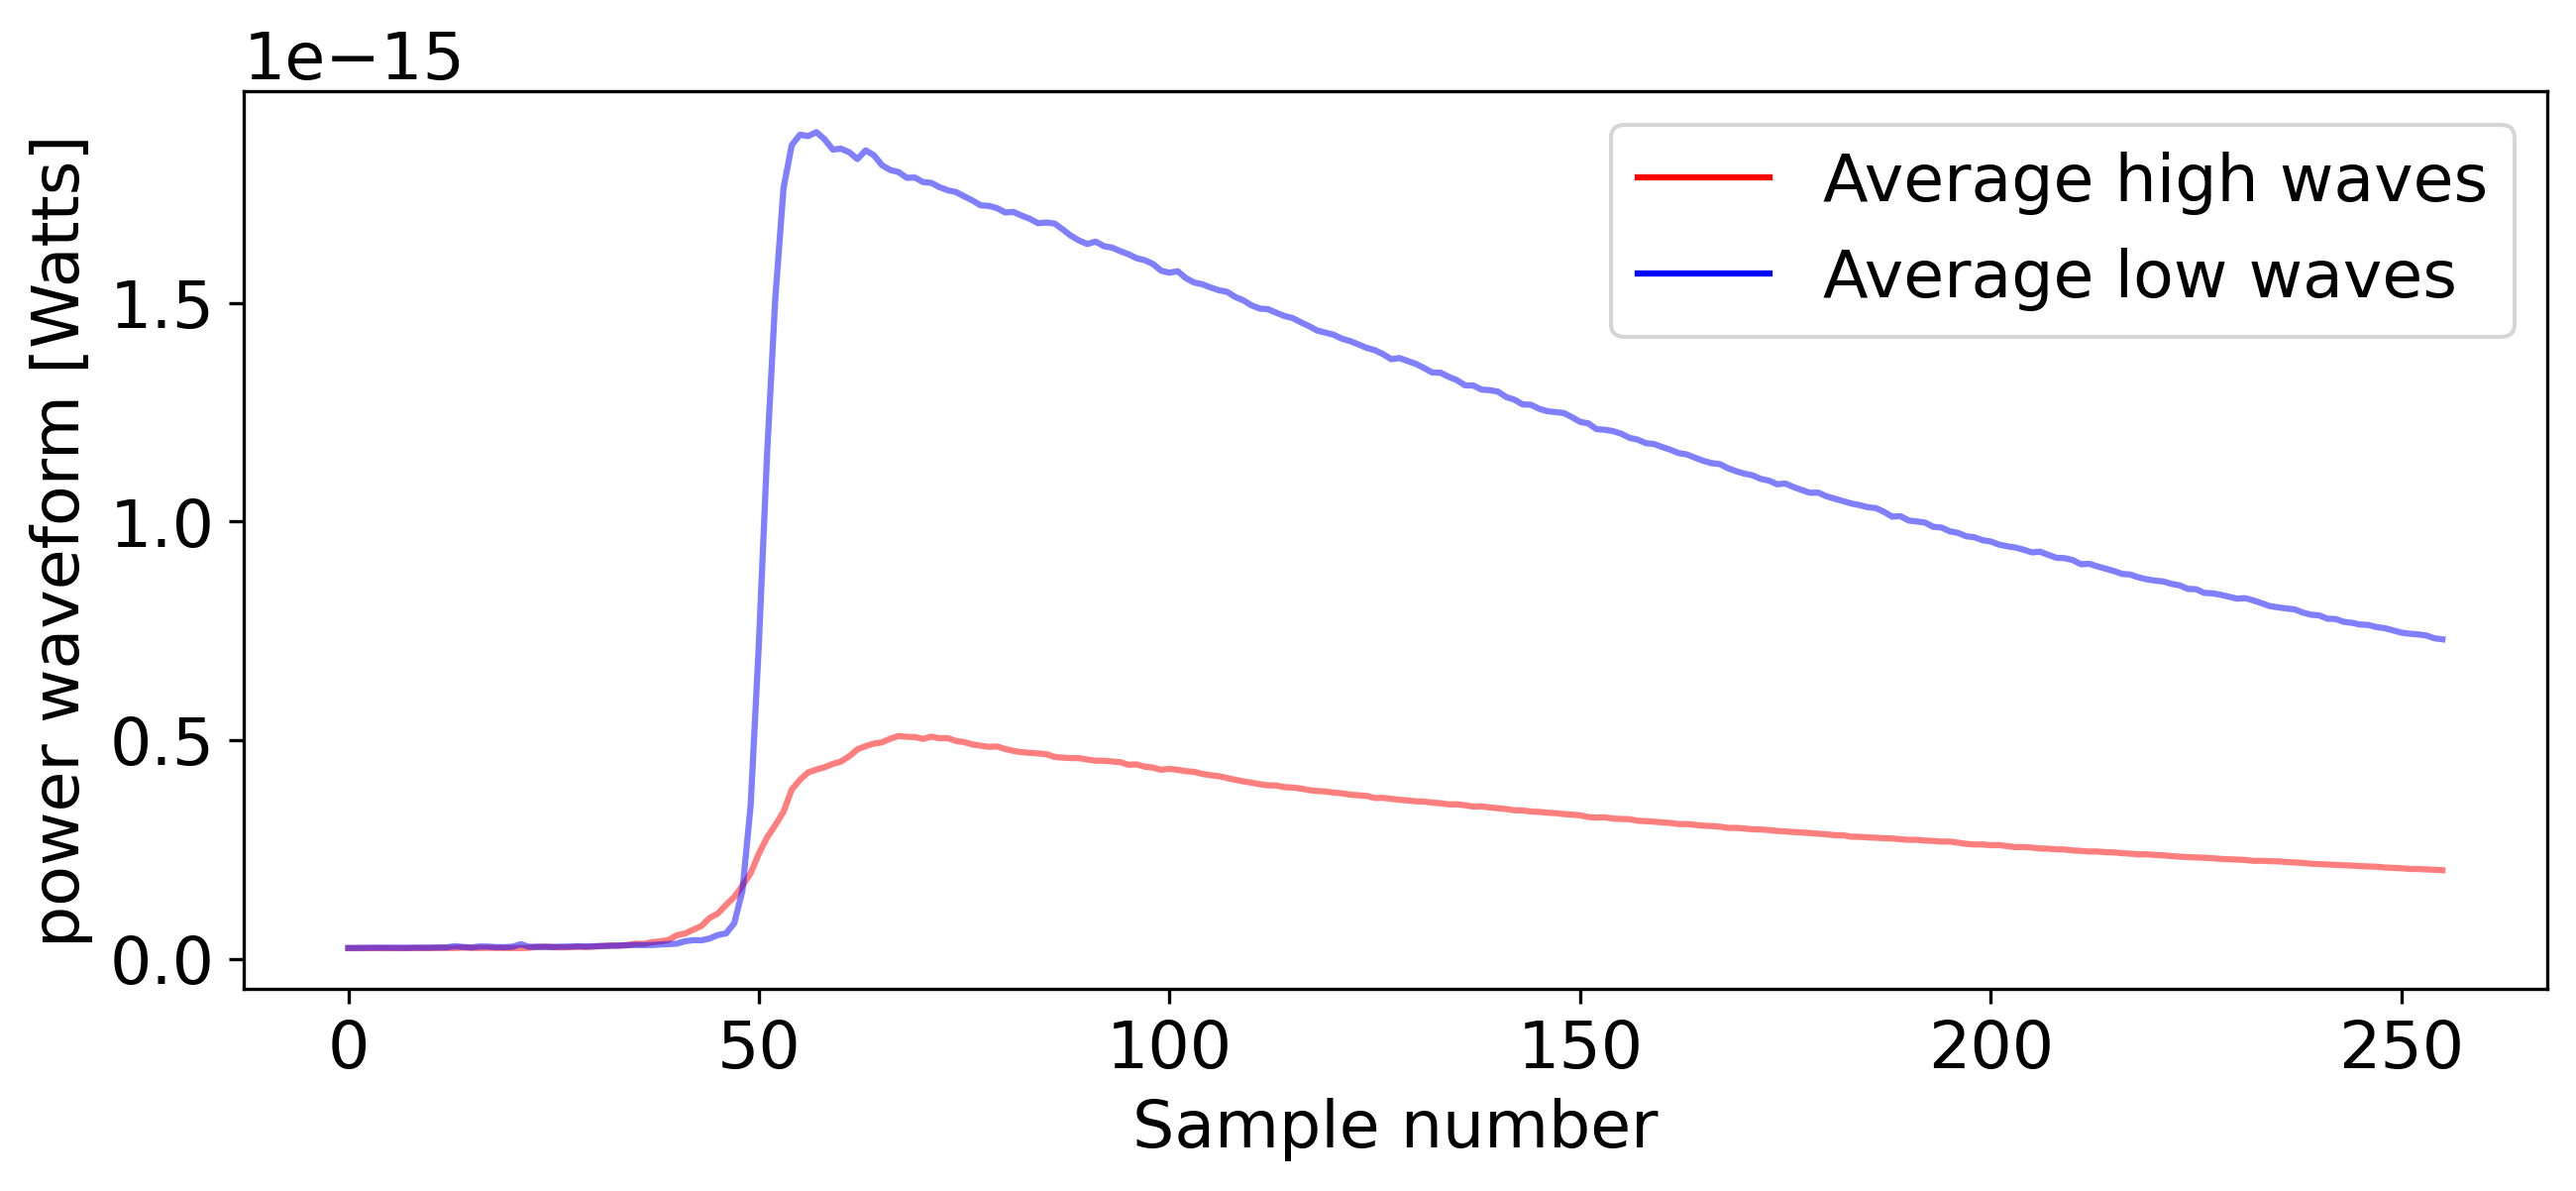

In [6]:
input_root = os.path.join(MYPATH,'S6_data')

# the SWH are only in the L2 files
# you can try the script below for either Low resolution or high resolution, but take care to be homogeneous 
# L1B and L2 files must be at the same resolution - otherwise the indexes won't match

input_pathWF = 'S6A_P4_1B_LR______20210907T150745_20210907T160358_20210928T114951_3373_030_165_082_EUM__OPE_NT_F03.SEN6'
#input_pathWF = 'S6A_P4_1B_HR______20210907T150745_20210907T160322_20210929T181726_3337_030_165_082_EUM__OPE_NT_F03.SEN6'
input_fileWF = 'measurement.nc'
my_fileWF    = os.path.join(input_root,input_pathWF,input_fileWF)
nc20kuWF = xr.open_dataset(my_fileWF, group='data_20/ku')

#folder where the L2 file is
input_pathL2 = ''
input_fileL2 = 'S6A_P4_2__LR_STD__NT_030_165_20210907T150745_20210907T160358_F03.nc'
#input_fileL2 = 'S6A_P4_2__HR_STD__NT_030_165_20210907T150745_20210907T160322_F03.nc'
my_fileL2    = os.path.join(input_root,input_pathL2,input_fileL2)
nc20kuL2 = xr.open_dataset(my_fileL2, group='data_20/ku')

# read the variables
waveform_20_ku = nc20kuWF.variables['power_waveform'][:,:]
print(['array length: ', np.shape(waveform_20_ku)])
waveform_scale_factor = nc20kuWF.variables['waveform_scale_factor'][:]
swh_ocean_20_ku = nc20kuL2.variables['swh_ocean'][:]
surface_type_20 = nc20kuL2.variables['surface_classification_flag'][:]
nc20kuWF.close()
nc20kuL2.close()

# find the 2% and 98% values of SWH
low_percentage = 2
high_percentage = 100 - low_percentage
#excluding data not on ocean
swh_ocean_20_ku[surface_type_20 != 0.0] = np.nan

SWH_bot = np.percentile(swh_ocean_20_ku[np.isfinite(swh_ocean_20_ku)], low_percentage)
SWH_top = np.percentile(swh_ocean_20_ku[np.isfinite(swh_ocean_20_ku)], high_percentage)

print(str(low_percentage)+'% SWH Ku for the track', SWH_bot)
print(str(high_percentage)+'% SWH Ku for the track', SWH_top)

lowwaves = np.where( swh_ocean_20_ku <= SWH_bot )[0]
highwaves = np.where( swh_ocean_20_ku >= SWH_top )[0]

lowwaves_index=np.asarray(lowwaves).astype(int)
highwaves_index=np.asarray(highwaves).astype(int)
 
#wvf_low = np.nanmean(waveform_20_ku[lowwaves_index,:], axis = 0)
wvf_low = np.nanmean(waveform_20_ku[lowwaves_index][:]*waveform_scale_factor[lowwaves_index], axis = 0)
wvf_high = np.nanmean(waveform_20_ku[highwaves_index][:]*waveform_scale_factor[highwaves_index], axis = 0)

fig = plt.figure(figsize=(10, 4), dpi=300)
ax = plt.subplot(1,1,1)
ax.plot(wvf_high,'r', alpha=0.5)
ax.plot(wvf_low,'b', alpha=0.5)

plt.xlabel('Sample number', fontsize=16)
plt.ylabel('power waveform [Watts]',  fontsize=16)

red_line = mlines.Line2D([], [], color='red', label='Average high waves')
blue_line = mlines.Line2D([], [], color='blue', label='Average low waves')

plt.legend(handles=[red_line, blue_line])
plt.savefig('S6_waveforms_hurricanelarry')
plt.show()

The significant wave height is obtained by analyzing the shape of the altimeter radar beam reflected on the sea surface (radar echo). A rather flat, or slowly rising, return signal indicates that waves are high (the signal bounced back on the wave crests, middle and then troughs) and, conversely, a sharp rise in the return signal indicates that the sea surface is calm (all the signal reflected on the surface at about the same time). 
It also impacts the power received back, the signal being scattered in all directions instead of in the satellite's direction. 

<br> <a href="./4_S6_SLAs.ipynb"><< 4 - S6 Sea-level anomalies </a><span style="float:right;"><a href="S6_overview.ipynb">Back to S6 overview >></a> 
    
   <a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>